🔎 What is ImageNet?

ImageNet is a huge collection of labeled images used for training and testing computer vision models.

The famous ImageNet Large Scale Visual Recognition Challenge (ILSVRC) ran from 2010–2017 and became the benchmark for deep learning breakthroughs (like AlexNet, ResNet, EfficientNet).

📂 The Data in ImageNet (ILSVRC)

Images

~1.2 million training images

50,000 validation images

100,000 test images

Each image is high-quality, downloaded from the internet (Flickr, search engines, etc.).

Classes

1,000 object categories (from the WordNet hierarchy).

Examples:

Animals 🐶🐱🐘 (dogs, cats, elephants, birds, fish…)

Objects 🚗📱🍎 (cars, phones, apples, guitars…)

Scenes 🌳🏠🏖 (forest, house, seashore…)

Tools ⚒️🔧 (hammer, wrench, screwdriver…).

Labels

Each image is labeled with one main category.

Example: An image of a golden retriever is labeled as "golden retriever" (not just “dog”).

Annotations

Some versions also include bounding boxes → rectangles around objects for detection tasks.

Later challenges had object detection, localization, and segmentation tracks, not just classification.

🏆 Tasks in the Competition

Image Classification → predict the correct class out of 1,000.

Object Detection → detect & locate multiple objects in an image (bounding boxes).

Image Localization → classify + give bounding box for the single main object.

Scene Parsing / Segmentation (added later).

✅ In summary:
The ImageNet competition used millions of real-world images across 1,000 diverse object categories, with labels and sometimes bounding boxes, making it the “gold standard” for testing how well AI can see and recognize things.

In [1]:
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm

print(tf.__version__)

2.19.0


load_data() downloads Fashion-MNIST if it’s not already cached.

It returns a tuple of two datasets:

(train_images, train_labels) → 60,000 training examples

(test_images, test_labels) → 10,000 test examples

Each image is a 28 × 28 grayscale numpy array (uint8 values from 0–255).

Each label is an integer from 0 to 9 representing a clothing category.

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

               

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


train_images.shape → (60000, 28, 28)
→ 60,000 images, each 28×28 pixels.

test_images.shape → (10000, 28, 28)
→ 10,000 images, each 28×28 pixels.

dtype → uint8 (unsigned 8-bit integers, pixel values from 0–255).

#Reshape data

train_images and test_images were (N, 28, 28) grayscale (1 channel).

[train_images] * 3 → makes 3 copies of the array.

np.stack(..., axis=-1) → stacks them along a new last axis.

📌 What np.stack([train_images]*3, axis=-1) Does

[train_images] * 3 → makes a list with 3 copies of the same array:

[train_images, train_images, train_images]

In [4]:
train_images_3ch = np.stack([train_images]*3, axis=-1)
test_images_3ch = np.stack([test_images]*3, axis=-1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))

#imagenet competition was for colored images hence 3 channels


Train_images.shape: (60000, 28, 28, 3), of uint8
Test_images.shape: (10000, 28, 28, 3), of uint8


#Resizing image

###The minimum image size expected by the VGG model is 32x32 so we need to resize our images

In [5]:
import cv2

def resize_image_array(img, img_size_dims):
    img = cv2.resize(img, dsize=img_size_dims)
    img = np.array(img, dtype=np.float32)
    return img


In [6]:
%%time

IMG_DIMS = (32, 32)

train_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in train_images_3ch])
test_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in test_images_3ch])

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 32, 32, 3), of float32
Test_images.shape: (10000, 32, 32, 3), of float32
CPU times: user 810 ms, sys: 428 ms, total: 1.24 s
Wall time: 1.25 s


#Vgg-19

In [7]:
# define input shape
INPUT_SHAPE = (32, 32, 3)

# get the VGG19 model
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False,
input_shape=INPUT_SHAPE)
#we are adding our own layer
vgg_layers.summary()
#include_top=False = we will add our own last layer

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

#Build CNN on the top of VGG19

In [8]:
# define sequential model
model = tf.keras.models.Sequential() #This creates a Sequential model, which is a linear stack of layers.
#You’ll be adding layers one after another.

# Add the vgg convolutional base model
model.add(vgg_layers)

# add flatten layer
model.add(tf.keras.layers.Flatten())

#Converts the 3D feature maps output from VGG19 into a 1D vector.

#Adds two fully connected layers with 256 neurons each.
#relu activation introduces non-linearity and helps learn complex features.
#Dropout(rate=0.3) randomly “drops” 30% of neurons during training to prevent overfitting.#

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 1, 1, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,224,074 (77.15 MB)

 Trainable params: 20,224,074 (77.15 MB)

 Non-trainable params: 0 (0.00 B)

monitor='val_loss': watches validation loss (on the 10% validation split).

patience=2: waits 2 epochs after the last improvement before stopping.

restore_best_weights=True: reverts the model weights to the best point (lowest validation loss).

verbose=1: prints a message when early stopping kicks in.

Inputs:

train_images_3ch_scaled: training data (normalized 3-channel images).

train_labels: integer labels for each image.

Batch size = 32: updates weights after every 32 samples → balance between speed and stability.

Validation split = 0.1: keeps 10% of training data aside for validation (not used in gradient updates).

Epochs = 100: upper bound, but early stopping will cut it short if no improvement.

Callbacks = [es_callback]: applies early stopping.

Verbose=1: shows progress bar and metrics at each epoch.

In [9]:
EPOCHS = 5 #100 full passes through the dataset
train_images_3ch_scaled = train_images_3ch / 255. #Raw pixel values range from 0–255.
#Dividing by 255 normalizes them to 0–1, which speeds up training and stabilizes gradients.#
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
restore_best_weights=True,
verbose=1)

history = model.fit(train_images_3ch_scaled, train_labels,
batch_size=32,
callbacks=[es_callback],
validation_split=0.1, epochs=EPOCHS,
verbose=1)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 146s 78ms/step - accuracy: 0.7269 - loss: 0.7884 - val_accuracy: 0.8840 - val_loss: 0.3175
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 124s 73ms/step - accuracy: 0.8922 - loss: 0.3188 - val_accuracy: 0.9003 - val_loss: 0.2720
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 143s 73ms/step - accuracy: 0.9100 - loss: 0.2615 - val_accuracy: 0.9080 - val_loss: 0.2507
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 141s 72ms/step - accuracy: 0.9216 - loss: 0.2280 - val_accuracy: 0.9035 - val_loss: 0.2700
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 142s 73ms/step - accuracy: 0.9304 - loss: 0.1977 - val_accuracy: 0.9200 - val_loss: 0.2202
Restoring model weights from the end of the best epoch: 5.


#Accuracy graphs

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

Creates a matplotlib figure (fig) with 1 row and 2 columns of subplots (ax is now an array with 2 axes objects).

figsize=(10,4) sets the figure’s width to 10 inches and height to 4 inches.

So you get two side-by-side plots.

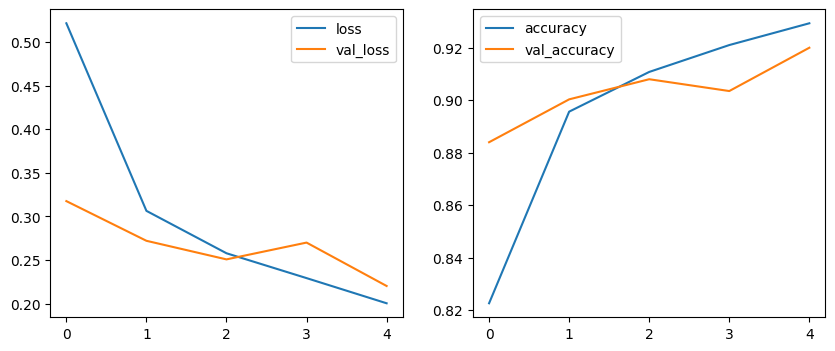

In [10]:
import pandas as pd
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);


#Test data accuracy

In [11]:
test_images_3ch_scaled = test_images_3ch / 255.
predictions = model.predict(test_images_3ch_scaled)
predictions[:5]

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


array([[4.02259417e-08, 2.01055972e-08, 7.05401746e-08, 1.70750781e-07,
        1.07599032e-08, 9.90590615e-06, 5.72130610e-08, 1.11693553e-05,
        1.37235663e-08, 9.99978542e-01],
       [5.93727054e-05, 3.43854595e-07, 9.99309897e-01, 1.75945279e-05,
        2.31627229e-04, 1.43647628e-06, 3.75965028e-04, 1.18818514e-06,
        6.10635766e-07, 1.97040413e-06],
       [1.76377156e-13, 1.00000000e+00, 7.44566735e-13, 1.49498400e-10,
        1.08706392e-12, 9.43541512e-12, 7.51678559e-13, 9.76433696e-14,
        9.82670651e-13, 6.30065748e-12],
       [3.74622798e-11, 1.00000000e+00, 1.76978598e-10, 1.19767884e-08,
        2.88287783e-10, 8.09283585e-10, 1.56851476e-10, 2.98200006e-11,
        1.86099899e-10, 5.09559617e-10],
       [5.83703697e-01, 1.22707395e-03, 4.32941914e-02, 1.98880117e-02,
        1.23498607e-02, 2.85848090e-03, 3.25375974e-01, 5.47729200e-03,
        3.53284739e-03, 2.29251757e-03]], dtype=float32)

In [12]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 0])

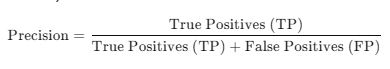

Of all the items the model predicted as class X, how many were actually class X?

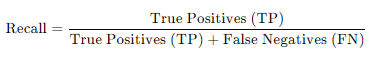

“Of all the actual items that truly belong to class X, how many did the model correctly predict as X?

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.90      0.87      1000
     Trouser       0.98      0.99      0.99      1000
    Pullover       0.82      0.93      0.87      1000
       Dress       0.89      0.95      0.92      1000
        Coat       0.88      0.84      0.86      1000
      Sandal       0.97      0.99      0.98      1000
       Shirt       0.86      0.66      0.75      1000
     Sneaker       0.98      0.92      0.95      1000
         Bag       0.98      0.99      0.99      1000
  Ankle boot       0.95      0.98      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.91     10000
weighted avg       0.92      0.92      0.91     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,904,2,26,18,1,0,42,0,7,0
Trouser,0,992,0,6,0,0,1,0,1,0
Pullover,8,2,927,12,35,0,16,0,0,0
Dress,11,10,9,947,8,0,13,0,2,0
Coat,2,2,71,54,838,0,31,0,2,0
Sandal,0,0,0,0,0,992,0,4,0,4
Shirt,141,2,94,30,70,0,658,0,5,0
Sneaker,0,0,0,0,0,27,0,924,0,49
Bag,3,2,1,1,2,1,0,0,989,1
Ankle boot,0,1,0,0,0,3,0,11,0,985


In [14]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


##Accuracy is 0.92

In [17]:
# define input shape
INPUT_SHAPE = (32, 32, 3)

# get the VGG19 model
ResNet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
input_shape=INPUT_SHAPE)
#we are adding our own layer
ResNet50.summary()

# define sequential model
model = tf.keras.models.Sequential() #This creates a Sequential model, which is a linear stack of layers.
#You’ll be adding layers one after another.

# Add the vgg convolutional base model
model.add(ResNet50)

# add flatten layer
model.add(tf.keras.layers.Flatten())

#Converts the 3D feature maps output from VGG19 into a 1D vector.

#Adds two fully connected layers with 256 neurons each.
#relu activation introduces non-linearity and helps learn complex features.
#Dropout(rate=0.3) randomly “drops” 30% of neurons during training to prevent overfitting.#

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

# view model layers
model.summary()


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,180,618 (92.24 MB)

 Trainable params: 24,127,498 (92.04 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [18]:
EPOCHS = 5 #100 full passes through the dataset
train_images_3ch_scaled = train_images_3ch / 255. #Raw pixel values range from 0–255.
#Dividing by 255 normalizes them to 0–1, which speeds up training and stabilizes gradients.#
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
restore_best_weights=True,
verbose=1)

history = model.fit(train_images_3ch_scaled, train_labels,
batch_size=32,
callbacks=[es_callback],
validation_split=0.1, epochs=EPOCHS,
verbose=1)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 131s 46ms/step - accuracy: 0.4669 - loss: 1.6574 - val_accuracy: 0.8495 - val_loss: 0.4305
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 89s 28ms/step - accuracy: 0.8160 - loss: 0.5507 - val_accuracy: 0.8887 - val_loss: 0.3096
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.8697 - loss: 0.3867 - val_accuracy: 0.9037 - val_loss: 0.2632
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.8884 - loss: 0.3254 - val_accuracy: 0.9135 - val_loss: 0.2398
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9054 - loss: 0.2760 - val_accuracy: 0.9165 - val_loss: 0.2408
Restoring model weights from the end of the best epoch: 4.


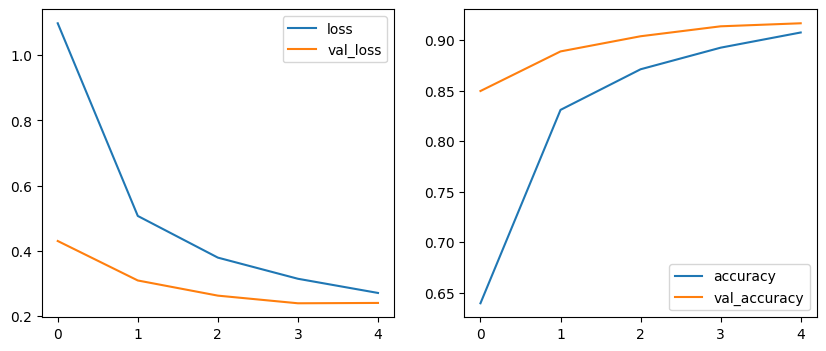

In [19]:
import pandas as pd
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [20]:
test_images_3ch_scaled = test_images_3ch / 255.
predictions = model.predict(test_images_3ch_scaled)
predictions[:5]

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step


array([[1.35315545e-08, 3.03676329e-09, 1.40828345e-08, 2.90633047e-08,
        1.35261367e-08, 3.84431672e-07, 1.83211881e-08, 8.17153796e-06,
        9.21500742e-08, 9.99991298e-01],
       [1.99686168e-04, 1.55232647e-05, 9.95291293e-01, 2.91558790e-05,
        1.52108120e-03, 1.06904427e-05, 2.88677216e-03, 9.87942713e-06,
        3.32749296e-05, 2.63289758e-06],
       [9.29742828e-12, 1.00000000e+00, 3.79963977e-10, 5.68857239e-10,
        1.25232946e-09, 1.53843586e-13, 1.74962533e-09, 3.24136334e-13,
        1.74639125e-13, 1.68167813e-12],
       [1.18997809e-06, 9.99969602e-01, 3.39067071e-07, 2.05320466e-05,
        3.43445095e-06, 6.03347488e-08, 4.45695923e-06, 4.29404672e-08,
        2.33817644e-07, 9.40603968e-08],
       [1.98863596e-01, 1.73951045e-03, 1.48423716e-01, 2.05750596e-02,
        4.40846831e-02, 1.11941097e-03, 5.79130888e-01, 1.88562868e-03,
        1.98595342e-03, 2.19159038e-03]], dtype=float32)

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.90      0.87      1000
     Trouser       0.98      0.99      0.99      1000
    Pullover       0.82      0.93      0.87      1000
       Dress       0.89      0.95      0.92      1000
        Coat       0.88      0.84      0.86      1000
      Sandal       0.97      0.99      0.98      1000
       Shirt       0.86      0.66      0.75      1000
     Sneaker       0.98      0.92      0.95      1000
         Bag       0.98      0.99      0.99      1000
  Ankle boot       0.95      0.98      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.91     10000
weighted avg       0.92      0.92      0.91     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,904,2,26,18,1,0,42,0,7,0
Trouser,0,992,0,6,0,0,1,0,1,0
Pullover,8,2,927,12,35,0,16,0,0,0
Dress,11,10,9,947,8,0,13,0,2,0
Coat,2,2,71,54,838,0,31,0,2,0
Sandal,0,0,0,0,0,992,0,4,0,4
Shirt,141,2,94,30,70,0,658,0,5,0
Sneaker,0,0,0,0,0,27,0,924,0,49
Bag,3,2,1,1,2,1,0,0,989,1
Ankle boot,0,1,0,0,0,3,0,11,0,985
